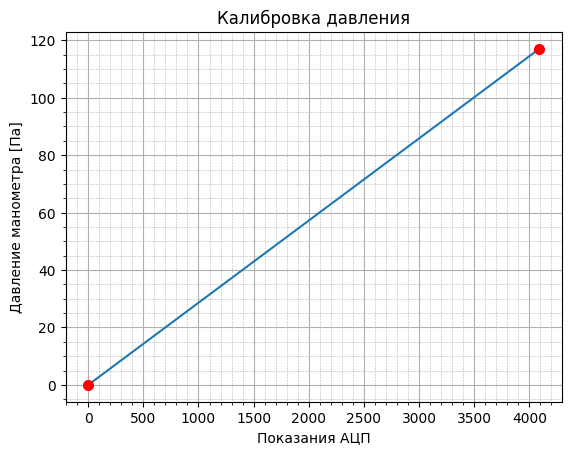

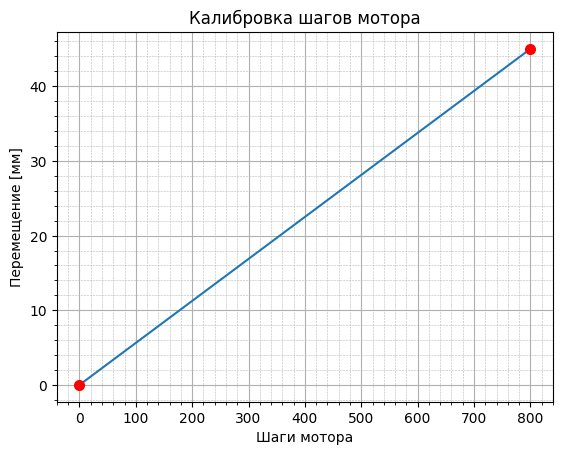

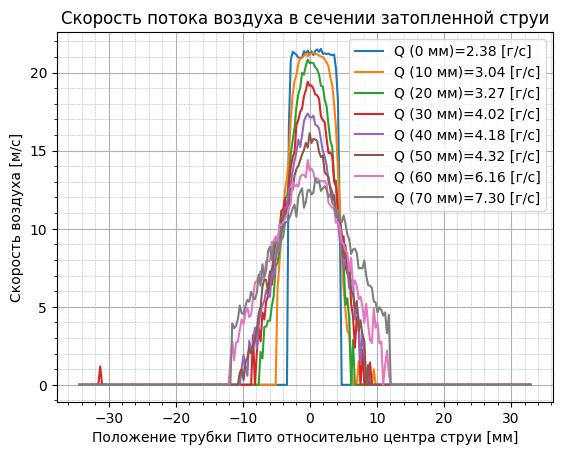

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Калибровка давления
empty=(pd.read_csv('./data_empty_presure.txt',header=None)).to_numpy()
empty=np.mean(empty[:,0])
inside=(pd.read_csv('./data_inside_presure.txt',header=None)).to_numpy()
inside=np.mean(inside[:,0])
adc_to_pascal=117/(inside-empty)
plt.plot([0,inside-empty],[0,117], '-o',ms=7,markerfacecolor='red',markeredgecolor='red')
plt.minorticks_on()
plt.grid(True, which='minor' , lw=0.4, alpha =0.9, linestyle='--')
plt.grid()
plt.xlabel('Показания АЦП')
plt.ylabel('Давление манометра [Па]')
plt.title('Калибровка давления')
#plt.savefig('./Калибровка давления1',dpi=200,bbox_inches='tight',facecolor='white',edgecolor='none',transparent=False)
plt.show()

#Калибровка шагов
steps_to_mm=45/800
plt.plot([0,800],[0,45],'-o',ms=7, markerfacecolor='red',markeredgecolor='red')
plt.minorticks_on()
plt.grid(True, which='minor' , lw=0.4, alpha =0.9, linestyle='--')
plt.grid()
plt.xlabel('Шаги мотора')
plt.ylabel('Перемещение [мм]')
plt.title('Калибровка шагов мотора')
#plt.savefig('./Калибровка шагов мотора',dpi=200,bbox_inches='tight',facecolor='white',edgecolor='none',transparent=False)
plt.show()

#Убдаление шумов по краям
def delete_noise(mas,l,n,num1,num2):
    #слева
    stop=1
    mean_old=np.mean(mas[:n,0])
    for i in range(n,l,n):
        mean_new=np.mean(mas[i:i+n,0])
        if (mean_new>mean_old*num1):
            stop=i
            break
    for i in range(stop):
        mas[i,0]=0
    #справа
    stop=1
    mean_old=np.mean(mas[l-1:l-1-n:-1,0])
    for i in range(n,l,n):
        mean_new=np.mean(mas[l-1-i:l-1-i-n:-1,0])
        if (mean_new>mean_old*num2):
            stop=i
            break
    for i in range(l-1,l-1-stop,-1):
        mas[i,0]=0

#Убдаление шумов по краям
files=['./data_distance_0.txt', './data_distance_10.txt', './data_distance_20.txt', './data_distance_30.txt', './data_distance_40.txt', './data_distance_50.txt', './data_distance_60.txt', './data_distance_70.txt']
num1=[2,2,2,2,2,2,2.3,1.5]
num2=[2,2,2,2,2,2,2.3,1.7]
for i in range (8):
    data=(pd.read_csv(files[i],header=None,dtype=float)).to_numpy()
    data[:,0]-=empty
    for j in range (len(data[:,0])):
        if (data[j,0]<0):
            data[j,0]=0
    data[:,0]*=adc_to_pascal
    for j in range(len(data[:,0])):
        data[j,0]=(data[j,0]*2/1.2)**0.5
    data[:,1]*=5
    data[:,1]*=steps_to_mm
    delete_noise(data,len(data[:,0]),5,num1[i],num2[i])
    files[i]=data

#Центровка графика
peaks=[]
for i in range (1,8):
    data=files[i]
    peaks.append(data[np.argmax(data[:,0]),1])
    
peak=np.mean(peaks)
for i in range (8):
    data=files[i]
    data[:,1]-=peak
    files[i]=data

#Поиск расхода
rashod=[]
for i in range (8):
    rashod.append(f'Q ({i*10} мм)=')
    data=files[i]
    data[:,1]*=1e-3
    Q=2*np.pi*1.2*(np.trapezoid(data[:,0]*np.abs(data[:,1]),(data[:,1])))*1e3
    rashod[i]+=f'{Q:.2f}' + ' [г/c]'
    data[:,1]*=1e3

#Печать графика
for i in range (8):
    data=files[i]
    plt.plot(data[:,1],data[:,0], label=rashod[i])
plt.minorticks_on()
plt.grid(True, which='minor' , lw=0.4, alpha =0.9, linestyle='--')
plt.grid()
plt.xlabel('Положение трубки Пито относительно центра струи [мм]')
plt.ylabel('Скорость воздуха [м/с]')
plt.title('Скорость потока воздуха в сечении затопленной струи')
plt.legend()
#plt.savefig('./График с расходом(с шумом)',dpi=200,bbox_inches='tight',facecolor='white',edgecolor='none',transparent=False)
plt.show()